Setting up the Algorithms and libraries to use.

In [1]:
import osmnx
from smart_mobility_utilities.common import cost, Node
from smart_mobility_utilities.viz import  draw_map
import osmnx as ox
import math
import heapq
from collections import deque
import folium
import time



def bfs_shortest_path(graph, start, goal):
    visited = set()
    queue = deque([[start]])

    while queue:
        path = queue.popleft()
        node = path[-1]
        if node == goal:
            return path
        if node not in visited:
            neighbors = [neighbor for neighbor in graph.neighbors(node)]
            for neighbor in neighbors:
                newPath = list(path)
                newPath.append(neighbor)
                queue.append(newPath)
            visited.add(node)

    return None


def dfs_shortest_path(graph, start, goal):
    visited = set()
    stack = [[start]]

    while stack:
        path = stack.pop()
        node = path[-1]
        if node == goal:
            return path
        if node not in visited:
            neighbors = [neighbor for neighbor in graph.neighbors(node)]
            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                stack.append(new_path)
            visited.add(node)

    return None


def dijkstra(G, start_node, end_node):
    distances = {node: float('inf') for node in G.nodes}
    parents = {node: None for node in G.nodes}
    unvisited = [(0, start_node)]  # (distance, node)

    distances[start_node] = 0

    while unvisited:
        # Get the node with the smallest distance from the unvisited list
        current_distance, current_node = min(unvisited, key=lambda x: x[0])
        unvisited.remove((current_distance, current_node))

        if current_node == end_node:
            path = deque()
            while current_node is not None:
                path.appendleft(current_node)
                current_node = parents[current_node]
            return list(path)

        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor][0]
            distance = edge_data['length']
            new_distance = current_distance + distance

            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                parents[neighbor] = current_node
                unvisited.append((new_distance, neighbor))

    return None


def heuristic(node1, node2):
    lat1, long1 = node1['y'], node1['x']
    lat2, long2 = node2['y'], node2['x']
    return math.sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)

def AStar(G, start_node, end_node):
    distances = {node: float('inf') for node in G.nodes}
    parents = {node: None for node in G.nodes}
    unvisited = [(0, start_node)]  # (distance + heuristic, node)

    distances[start_node] = 0

    while unvisited:
        # Get the node with the smallest distance + heuristic from the unvisited list
        current_distance, current_node = min(unvisited, key=lambda x: x[0])
        unvisited.remove((current_distance, current_node))

        if current_node == end_node:
            path = deque()
            while current_node is not None:
                path.appendleft(current_node)
                current_node = parents[current_node]
            return list(path)

        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor][0]
            distance = edge_data['length']
            new_distance = current_distance + distance
            heuristic_cost = heuristic(G.nodes[current_node], G.nodes[neighbor])

            if new_distance + heuristic_cost < distances[neighbor]:
                distances[neighbor] = new_distance
                parents[neighbor] = current_node
                unvisited.append((new_distance + heuristic_cost, neighbor))  # Add the new node without updating the distances

    return None



Setting up inputs. Configuring data to load small map first in picadilly region

Node ID: 3351356, Latitude: 53.4736431, Longitude: -2.2259951
Node ID: 3351359, Latitude: 53.4735036, Longitude: -2.2255398
Node ID: 3353193, Latitude: 53.4752126, Longitude: -2.2279253
Node ID: 3353196, Latitude: 53.4744334, Longitude: -2.2273541
Node ID: 3353200, Latitude: 53.475035, Longitude: -2.2300446
Node ID: 3353206, Latitude: 53.4733461, Longitude: -2.2294605
Node ID: 3353211, Latitude: 53.4732945, Longitude: -2.2296389
Node ID: 3353217, Latitude: 53.4731428, Longitude: -2.2268279
Node ID: 3353218, Latitude: 53.4735501, Longitude: -2.227188
Node ID: 3353219, Latitude: 53.4724665, Longitude: -2.2263199
Node ID: 3353220, Latitude: 53.473307, Longitude: -2.225697
Node ID: 3353221, Latitude: 53.4730163, Longitude: -2.2245012
Node ID: 3353222, Latitude: 53.4733042, Longitude: -2.224308
Node ID: 3353226, Latitude: 53.4729, Longitude: -2.2240227
Node ID: 3353229, Latitude: 53.4724116, Longitude: -2.2238087
Node ID: 3353230, Latitude: 53.472772, Longitude: -2.2235324
Node ID: 3353232,

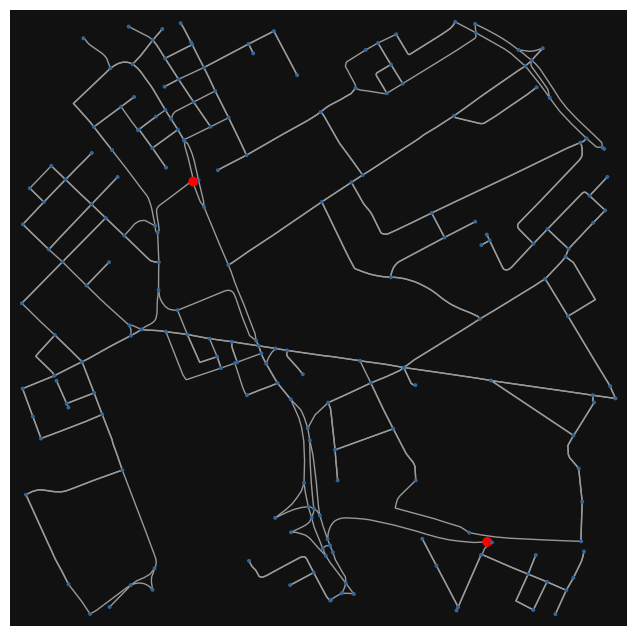

In [2]:
reference = (53.476877, -2.229807)#Picadilly region centre
#declaring the are to work with i.e. size, network type etc.
G = osmnx.graph_from_point(reference, dist=500, clean_periphery=True, simplify=True, network_type="drive")

#finds the nearest node to the given co-ordinates- longitude, latitude
nodes = ox.distance.nearest_nodes(G, reference[1], reference[0], return_dist=False)
#finds all the nodes in the given map- nodeID,latitude,longitude
for node, data in G.nodes(data=True):
    print(f"Node ID: {node}, Latitude: {data['y']}, Longitude: {data['x']}")

#node values for two origin and destination
markedNodes = [3351359, 3590411971]

# marking both the source and destination node and displaying as a figure

nodeColour = ['red' if node in markedNodes else '#336699' for node in G.nodes()]
nodeSize = [50 if node in markedNodes else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=nodeSize, node_color=nodeColour, node_zorder=2)


# getting the nodes from the graph using node id 
origin = Node(graph=G, osmid=3351359)
destination = Node(graph=G, osmid=3590411971)

#setting variables to node to be used for algorithm- root node, end node
start_node = origin.osmid
end_node = destination.osmid



BFS Routing. In this section of the we are testing the performance of Bread-First Search algorithm using the map/graph data generated.


Time taken by bfs_shortest_path: 0.0 seconds
Route: [3351359, 32058592, 9229927460, 3353206, 9081073387, 3353211, 9229927456, 1512225162, 1357129724, 3420188988, 3836364042, 3836364043, 9372848368, 3836364047, 1681211395, 1674311001, 1674311006, 290428116, 4839347, 889325537, 3590411971]
Cost (number of edges): 20
Cost: 1280.845


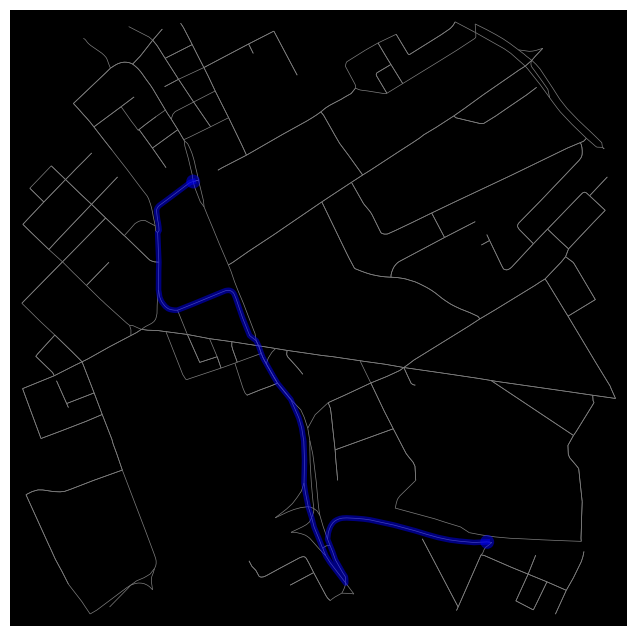

In [3]:
# Find the shortest path using BFS

start_time = time.time()

route = bfs_shortest_path(G, start_node, end_node)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken by bfs_shortest_path: {execution_time} seconds")

#saving map output as html file
location = [G.nodes[route[0]]['y'], G.nodes[route[0]]['x']]
m = folium.Map(location, zoom_start=15, tiles='OpenStreetMap')

# Plot the route on the folium map
mapbfs = ox.plot_route_folium(G, route, route_map=m, popup_attribute=None, color='blue', opacity=0.7, weight=5)


#m = draw_route_on_map(G, route)
m.save("routebfs.html")

print(f"Route: {route}")
print(f"Cost (number of edges): {len(route) - 1}")
print(f"Cost: {cost(G,route)}")

# Plot the route on the map
route_graph = G.subgraph(route)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='k', edge_color='gray', edge_linewidth=0.5, route_color='blue')








DFS Routing. In this section of the we are testing the performance of Depth-First Search algorithm using the map/graph data generated.


Time taken by dfs_shortest_path: 0.0010013580322265625 seconds
Route: [3351359, 32058592, 9229927460, 3353206, 9081073387, 3353211, 9229927456, 1512225162, 1357129724, 3420188988, 3836364042, 3836364043, 3636168, 9229731091, 3634977, 3450925, 3450923, 9871154956, 889528202, 1681233028, 1681256390, 4831706, 6028232919, 4839349, 4839347, 889325537, 3590411971]
Cost (number of edges): 26
Cost: 1811.615


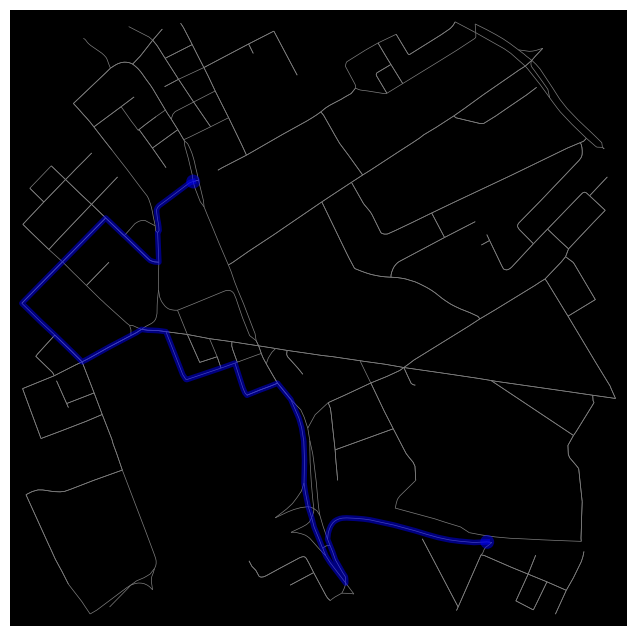

In [14]:
start_time = time.time()
route = dfs_shortest_path(G, start_node, end_node)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken by dfs_shortest_path: {execution_time} seconds")

location = [G.nodes[route[0]]['y'], G.nodes[route[0]]['x']]
dfs_map = folium.Map(location, zoom_start=15, tiles='OpenStreetMap')

# Plot the route on the folium map
ox.plot_route_folium(G, route, route_map=dfs_map, popup_attribute=None, color='blue', opacity=0.7, weight=5)

dfs_map.save("routedfs.html")

print(f"Route: {route}")
print(f"Cost (number of edges): {len(route) - 1}")
print(f"Cost: {cost(G,route)}")

route_graph = G.subgraph(route)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='k', edge_color='gray', edge_linewidth=0.5, route_color='blue')





Dijkstra's Routing. In this section of the we are testing the performance of Dijkstra's algorithm using the map/graph data generated.


Time taken by Dijkstra: 0.08109259605407715 seconds
Route: [6587512, 6202370189, 1812768592, 4618192, 30890511, 4618190, 30890512, 30890534, 27394006, 30890536, 30890543, 1687150469, 30891127, 643133, 30891124, 30891133, 643137, 3356365, 3356363, 9257753667, 643136, 1674299623, 9446128602, 1674309237, 643142, 4831114, 1944844959, 2003103595, 1944844951, 4831113, 4831112, 64698818, 4843841, 299138360, 1687154509, 889324644, 4843764, 1685993893, 1686003694, 1686003714, 7928455978, 1117141224, 5628819279, 1671920100, 1671920105, 3592349826, 3346317, 1671942528, 5632790290, 1750893816, 5632790266, 306553497, 306553474, 1777811659, 306553549, 1777812260, 306553490, 1804412318, 1841601431, 31372370]
Cost (number of edges): 59
Cost: 4621.35


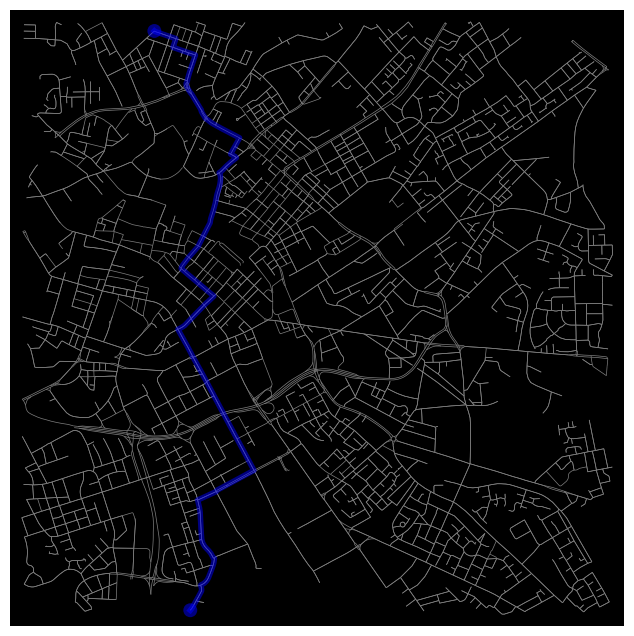

In [20]:
start_time = time.time()


route = dijkstra(G, start_node, end_node)
end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken by Dijkstra: {execution_time} seconds")
location = [G.nodes[route[0]]['y'], G.nodes[route[0]]['x']]
mapDijk = folium.Map(location, zoom_start=15, tiles='OpenStreetMap')

# Plot the route on the folium map
ox.plot_route_folium(G, route, route_map=mapDijk, popup_attribute=None, color='blue', opacity=0.7, weight=5)


#m = draw_route_on_map(G, route)
mapDijk.save("routeDijkstra.html")
print(f"Route: {route}")
print(f"Cost (number of edges): {len(route) - 1}")
print(f"Cost: {cost(G,route)}")

route_graph = G.subgraph(route)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='k', edge_color='gray', edge_linewidth=0.5, route_color='blue')



A* Algorithm's Routing. In this section of the we are testing the performance of A* algorithm using the map/graph data generated.


Time taken by A star: 0.026908397674560547 seconds
Route: [643133, 3356309, 9797368138, 1002563896, 9285624317, 1496838998, 1357134003, 1357134005, 9238183385, 9238183381, 9150269802, 6205745452, 3356331, 3356334, 3560125, 1681232973, 889528202, 9871154956, 3450923, 290428116, 4839347, 889325537, 3590411971, 3590411961, 1674315120, 1674316136, 1674315122, 1674317211, 1827306576, 2673079386, 2673079385, 277774005, 1825278031, 2003096198, 1752401207, 308099746, 4830782, 4830781, 299129542, 10314875028]
Cost (number of edges): 39
Cost: 2271.235


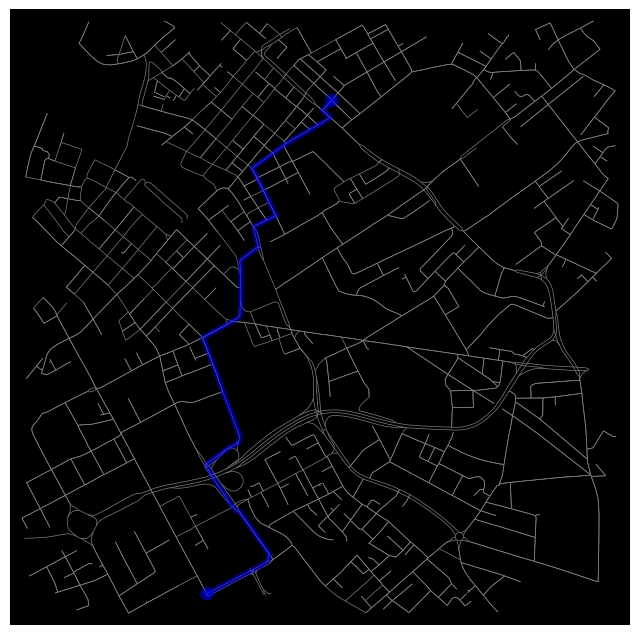

In [18]:

start_time = time.time()
route = AStar(G, start_node, end_node)

end_time = time.time()

execution_time = end_time - start_time

print(f"Time taken by A star: {execution_time} seconds")
location = [G.nodes[route[0]]['y'], G.nodes[route[0]]['x']]
mapAstar = folium.Map(location, zoom_start=15, tiles='OpenStreetMap')

# Plot the route on the folium map
ox.plot_route_folium(G, route, route_map=mapAstar, popup_attribute=None, color='blue', opacity=0.7, weight=5)



mapAstar.save("routeA_Star.html")
print(f"Route: {route}")
print(f"Cost (number of edges): {len(route) - 1}")
print(f"Cost: {cost(G,route)}")

route_graph = G.subgraph(route)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=4, node_size=0, bgcolor='k', edge_color='gray', edge_linewidth=0.5, route_color='blue')


Changing Map to a Medium size Map to test it with the algorithms above again.

Node ID: 643133, Latitude: 53.4684722, Longitude: -2.2356113
Node ID: 643136, Latitude: 53.4739439, Longitude: -2.2405403
Node ID: 643137, Latitude: 53.4711147, Longitude: -2.2380009
Node ID: 643142, Latitude: 53.4775249, Longitude: -2.2401879
Node ID: 643144, Latitude: 53.4717832, Longitude: -2.2348605
Node ID: 673994, Latitude: 53.4820722, Longitude: -2.2278592
Node ID: 3350582, Latitude: 53.4708688, Longitude: -2.2416581
Node ID: 3350586, Latitude: 53.4705455, Longitude: -2.2412147
Node ID: 3350591, Latitude: 53.4701502, Longitude: -2.2420253
Node ID: 3350592, Latitude: 53.4702087, Longitude: -2.2422299
Node ID: 3350597, Latitude: 53.4707446, Longitude: -2.2427043
Node ID: 3350598, Latitude: 53.4707988, Longitude: -2.2426736
Node ID: 3350600, Latitude: 53.4709913, Longitude: -2.2420757
Node ID: 3350601, Latitude: 53.471201, Longitude: -2.2425703
Node ID: 3350613, Latitude: 53.4714356, Longitude: -2.2388162
Node ID: 3350614, Latitude: 53.4715141, Longitude: -2.2389203
Node ID: 335126

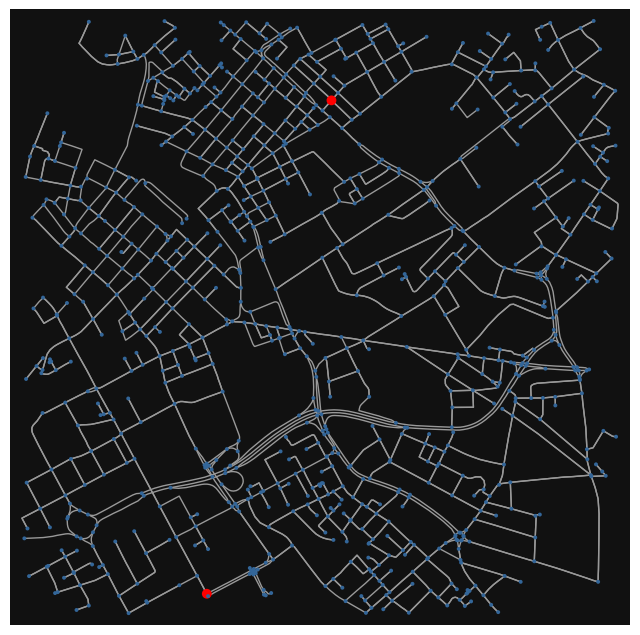

In [17]:
reference = (53.476877, -2.229807)#Picadilly region centre
#declaring the are to work with i.e. size, network type etc.
G = osmnx.graph_from_point(reference, dist=1000, clean_periphery=True, simplify=True, network_type="drive")

#finds the nearest node to the given co-ordinates- longitude, latitude
nodes = ox.distance.nearest_nodes(G, reference[1], reference[0], return_dist=False)
#finds all the nodes in the given map- nodeID,latitude,longitude
for node, data in G.nodes(data=True):
    print(f"Node ID: {node}, Latitude: {data['y']}, Longitude: {data['x']}")

#node values for two origin and destination
markedNodes = [643133, 10314875028]

# marking both the source and destination node and displaying as a figure

nodeColour = ['red' if node in markedNodes else '#336699' for node in G.nodes()]
nodeSize = [50 if node in markedNodes else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=nodeSize, node_color=nodeColour, node_zorder=2)


origin = Node(graph=G, osmid=643133)
destination = Node(graph=G, osmid=10314875028)

#setting variable to node ids to be used for algorithm
start_node = origin.osmid
end_node = destination.osmid

Configuring input data to change to a Large map data to test the algorithms earlier.

Node ID: 234984, Latitude: 53.4679343, Longitude: -2.2462118
Node ID: 643133, Latitude: 53.4684722, Longitude: -2.2356113
Node ID: 643136, Latitude: 53.4739439, Longitude: -2.2405403
Node ID: 643137, Latitude: 53.4711147, Longitude: -2.2380009
Node ID: 643142, Latitude: 53.4775249, Longitude: -2.2401879
Node ID: 643144, Latitude: 53.4717832, Longitude: -2.2348605
Node ID: 643145, Latitude: 53.4671096, Longitude: -2.2294494
Node ID: 643147, Latitude: 53.46204, Longitude: -2.2234345
Node ID: 673994, Latitude: 53.4820722, Longitude: -2.2278592
Node ID: 674003, Latitude: 53.4792737, Longitude: -2.2545161
Node ID: 674004, Latitude: 53.4783098, Longitude: -2.2495709
Node ID: 3346148, Latitude: 53.4768796, Longitude: -2.2569182
Node ID: 3346162, Latitude: 53.4764741, Longitude: -2.2543709
Node ID: 3346163, Latitude: 53.4764497, Longitude: -2.2541878
Node ID: 3346165, Latitude: 53.4760636, Longitude: -2.254513
Node ID: 3346166, Latitude: 53.4756266, Longitude: -2.254834
Node ID: 3346170, Latit

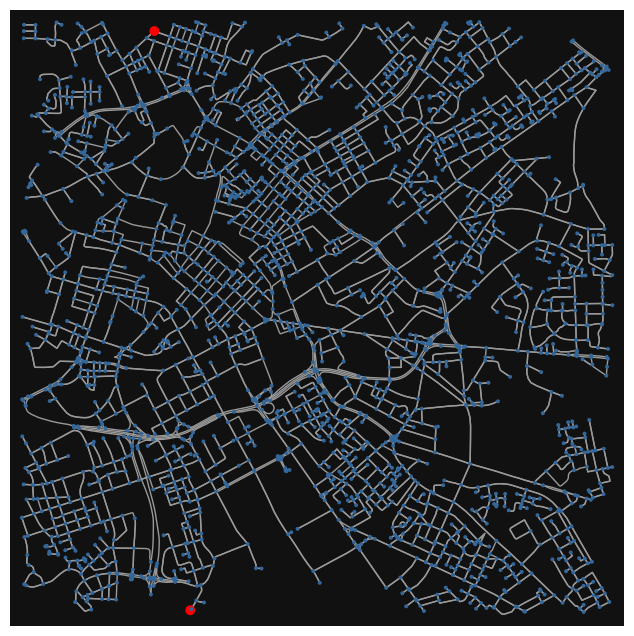

In [19]:

reference = (53.476877, -2.229807)#Picadilly region centre
#declaring the are to work with i.e. size, network type etc.
G = osmnx.graph_from_point(reference, dist=1800, clean_periphery=True, simplify=True, network_type="drive")

#finds the nearest node to the given co-ordinates- longitude, latitude
nodes = ox.distance.nearest_nodes(G, reference[1], reference[0], return_dist=False)
#finds all the nodes in the given map- nodeID,latitude,longitude
for node, data in G.nodes(data=True):
    print(f"Node ID: {node}, Latitude: {data['y']}, Longitude: {data['x']}")

#node values for two origin and destination
markedNodes = [6587512, 31372370]

# marking both the source and destination node and displaying as a figure

nodeColour = ['red' if node in markedNodes else '#336699' for node in G.nodes()]
nodeSize = [50 if node in markedNodes else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=nodeSize, node_color=nodeColour, node_zorder=2)


#converting nodeID's to nodes on the graphs to be used for routing
origin = Node(graph=G, osmid=6587512)
destination = Node(graph=G, osmid=31372370)


start_node = origin.osmid
end_node = destination.osmid